In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

### Explicit one-step ODE methods

In [5]:
def forward_euler(f, x0, h, n):
    ### Implements Forward Euler
    xk = np.zeros((x0.size, n+1), dtype = 'd')
    xk[:,0] = np.copy(x0)
    
    t = 0
    tk = np.zeros((n+1,), dtype = 'd')
    for j in range(n):
        t += h
        tk[j+1]  = t
        xk[:,j+1] = xk[:,j] + h*f(t, xk[:,j])
    
    return tk, xk


def heun(f, x0, h, n):
    ### Implements Heun's method
    xk = np.zeros((x0.size, n+1), dtype = 'd')
    xk[:,0] = np.copy(x0)
    
    t = 0
    tk = np.zeros((n+1,), dtype = 'd')
    for j in range(n):
        t += h
        tk[j+1]  = t
        fj = f(t, xk[:,j])         #First function evaluation
        xnew = xk[:,j] + h*fj      #First stage Forward Euler step
        xk[:,j+1] = xk[:,j] + (h/2)*(fj + f(t+h, xnew))  # Second stage: Second evaluation
    
    return tk, xk

#### Example 1: Simple ODE

We test on the problem
$$ x'(t) = -x(t) \qquad x(0) = 1,$$

with exact solution $x(t) = \exp(-t).$

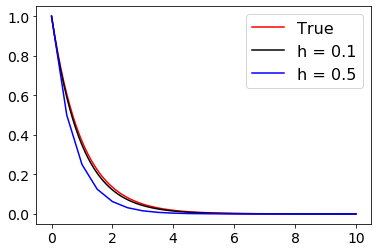

In [6]:
f = lambda t, x: -x

n = 100; h = 0.1
t1, xtraj1 = forward_euler(f, np.array([1]), h, n)

n = 20; h = 0.5
t2, xtraj2 = forward_euler(f, np.array([1]), h, n)

plt.plot(t1, np.exp(-t1), 'r-')
plt.plot(t1, xtraj1.flatten(), 'k-', t2, xtraj2.flatten(), 'b-')
plt.legend(('True', 'h = 0.1', 'h = 0.5'), fontsize = 16)

#### Example 2: System of ODEs

Consider the system of ODEs
$$z{'''} + z{''} + z = \sin(t)\qquad z(0) = 1, z'(0) = 0, z''(0) = -1, $$

which can be converted into the system of ODEs $\mathbf{x} = [z, z', z'']$ to get 

$$ \frac{d\mathbf{x}}{dt} = \mathbf{f}(t,\mathbf{x}) \qquad \mathbf{f}(t,\mathbf{x}) = \begin{bmatrix} x_2 \\ x_3 \\ \sin(t)  - x_1 - x_3 \end{bmatrix} $$

Text(0.5, 1.0, 'Heuns method')

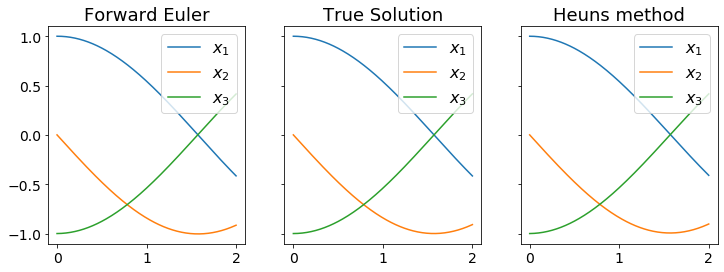

In [7]:
def fsys(t, x):    
    return np.array([x[1], x[2], np.sin(t) - x[0] - x[2]])


x0 = np.array([1,0,-1])

n = 200; h = 0.01
t1, xtraj1 = forward_euler(fsys, x0, h, n)


f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (12,4))
ax1.plot(t1, xtraj1.T)
ax1.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax1.set_title('Forward Euler', fontsize = 18)

ax2.plot(t1, np.cos(t1), t1, -np.sin(t1), t1, -np.cos(t1) )
ax2.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax2.set_title('True Solution', fontsize = 18)


t2, xtraj2 = heun(fsys, x0, h, n)
ax3.plot(t2, xtraj2.T)
ax3.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax3.set_title('Heuns method', fontsize = 18)

#### Example 3: Blow-up at finite time

Consider the ODE
$$ x'(t) = 1 + [x(t)]^2 \qquad x(0) =0. $$

The exact solution is $x(t) = \tan(t)$ which blows-up as $t\rightarrow \pi/2$. However, the numerical integrator will always produce a finite quantity.

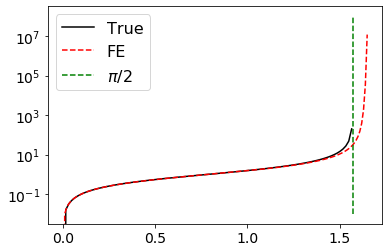

In [8]:
f3 = lambda t, x: 1 + x**2.

h = 0.01; n = np.int(1.65/h)
t1, xtraj1 = forward_euler(f3, np.array([0]), h, n)

tp = np.linspace(0,np.pi/2-0.005,100)
plt.semilogy(tp, np.tan(tp), 'k-')
plt.semilogy(t1, xtraj1.flatten(), 'r--')
plt.semilogy(np.pi/2*np.ones((100,)), np.logspace(-2,8,100), 'g--')
plt.legend(('True', 'FE', '$\pi/2$'), fontsize = 16)

### Implicit methods

We need to use a root finding algorithm, to compute the next iterate. Consider Backward Euler which requires to solve 

$$x_{k+1} = x_k + h f(t_{k+1}, x_{k+1}). $$ 

In [9]:
from scipy.optimize import fsolve

def backward_euler(f, x0, h, n):
    ### Implements Backward Euler
    xk = np.zeros((x0.size, n+1), dtype = 'd')
    xk[:,0] = np.copy(x0)
    
    t = 0
    tk = np.zeros((n+1,), dtype = 'd')
    for j in range(n):
        t += h
        tk[j+1]  = t
        
        #Compute the Forward Euler as an initial guess           
        xg = xk[:,j] + h*f(t, xk[:,j])
                   
        # Compute the root of F(u) = u - x_k - h*f(t_{k+1}, u)
        F = lambda u: u - xk[:,j] - h*f(t+h, u)
        xkp1 = fsolve(F, xg)
        xk[:,j+1] = xkp1

        
    return tk, xk

#### Test on Example 1

$$ x'(t) = -x(t) \qquad x(0) = 1.$$

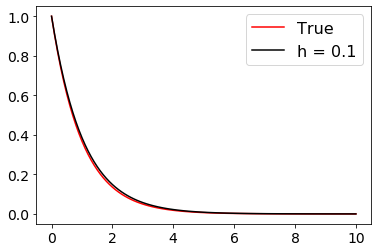

In [10]:
f = lambda t, x: -x

n = 100; h = 0.1
t1, xtraj1 = backward_euler(f, np.array([1]), h, n)

plt.plot(t1, np.exp(-t1), 'r-')
plt.plot(t1, xtraj1.flatten(), 'k-')
plt.legend(('True', 'h = 0.1', 'h = 0.5'), fontsize = 16)

#### Test on Example 2

Text(0.5, 1.0, 'Backward Euler method')

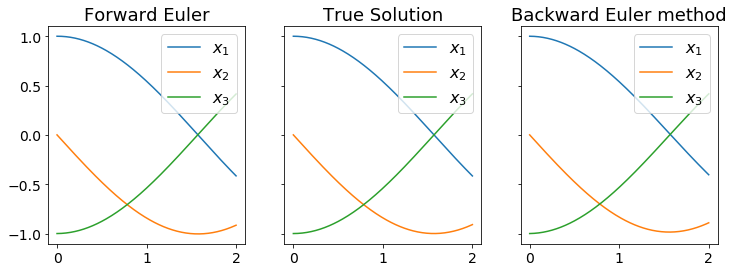

In [11]:
def fsys(t, x):    
    return np.array([x[1], x[2], np.sin(t) - x[0] - x[2]])


x0 = np.array([1,0,-1])

n = 200; h = 0.01
t1, xtraj1 = forward_euler(fsys, x0, h, n)


f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (12,4))
ax1.plot(t1, xtraj1.T)
ax1.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax1.set_title('Forward Euler', fontsize = 18)

ax2.plot(t1, np.cos(t1), t1, -np.sin(t1), t1, -np.cos(t1) )
ax2.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax2.set_title('True Solution', fontsize = 18)


t2, xtraj2 = backward_euler(fsys, x0, h, n)
ax3.plot(t2, xtraj2.T)
ax3.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax3.set_title('Backward Euler method', fontsize = 18)

#### Runge-Kutta method

We implement the RK4 method
$$ x_{k+1} = x_k + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4), $$

where $k_1,\dots,k_4$ have been defined in the lecture notes.

In [12]:
def RK4(f, x0, h, n):
    ### Implements RK4 method
    xk = np.zeros((x0.size, n+1), dtype = 'd')
    xk[:,0] = np.copy(x0)
    
    t = 0
    tk = np.zeros((n+1,), dtype = 'd')
    for j in range(n):
        t += h
        tk[j+1]  = t
        xp = xk[:,j]
        
        #Compute the four stages
        k1 = f(t,xp)
        k2 = f(t+h/2, xp + h*k1/2)
        k3 = f(t+h/2, xp + h*k2/2)
        k4 = f(t+h, xp + h*k3)
        
        #Combine the information from the four stages
        xk[:,j+1] = xp + (h/6)*(k1+ 2*k2 + 2*k3 + k4 )
    
    return tk, xk


Text(0.5, 1.0, 'RK4')

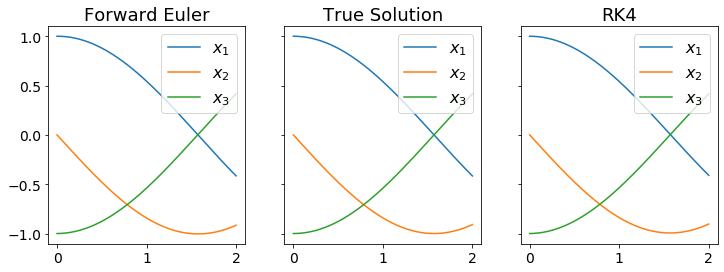

In [13]:
def fsys(t, x):    
    return np.array([x[1], x[2], np.sin(t) - x[0] - x[2]])


x0 = np.array([1,0,-1])

n = 200; h = 0.01
t1, xtraj1 = forward_euler(fsys, x0, h, n)


f, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (12,4))
ax1.plot(t1, xtraj1.T)
ax1.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax1.set_title('Forward Euler', fontsize = 18)

ax2.plot(t1, np.cos(t1), t1, -np.sin(t1), t1, -np.cos(t1) )
ax2.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax2.set_title('True Solution', fontsize = 18)


t2, xtraj2 = RK4(fsys, x0, h, n)
ax3.plot(t2, xtraj2.T)
ax3.legend(('$x_1$', '$x_2$', '$x_3$' ), fontsize = 16)
ax3.set_title('RK4', fontsize = 18)

### Comparing the global error

#### Example 1: simple ODE 

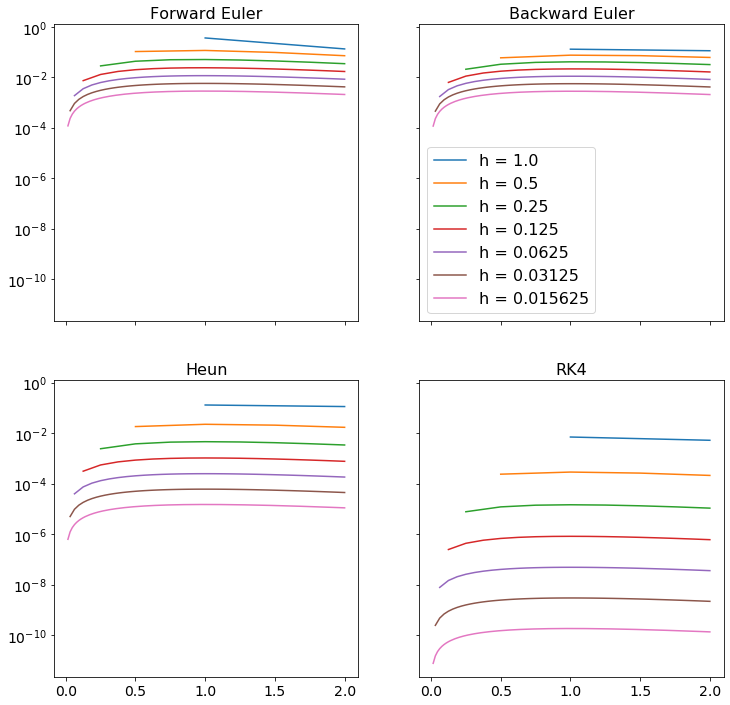

In [14]:
T = 2
hlst = 2.**(-np.arange(0,7))

fexp = lambda t, x: -x
x0 = np.array([1])


f, axarray = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12,12))
for j, h in enumerate(hlst):
    n = np.int(T/h)
    
    #Forward Euler
    t1, xtraj1 = forward_euler(fexp, x0, h, n)
    err1 = np.abs(np.exp(-t1)-xtraj1[0,:])
    axarray[0,0].semilogy(t1[1:], err1[1:])
    
    #Backward Euler
    t3, xtraj3 = backward_euler(fexp, x0, h, n)
    err3 = np.abs(np.exp(-t3)-xtraj3[0,:])
    axarray[0,1].semilogy(t3[1:], err3[1:])
    
    #Heun's method
    t2, xtraj2 = heun(fexp, x0, h, n)
    err2 = np.abs(np.exp(-t2)-xtraj2[0,:])
    axarray[1,0].semilogy(t2[1:], err2[1:])
    
    
    #RK4
    t4, xtraj4 = RK4(fexp, x0, h, n)
    err4 = np.abs(np.exp(-t4)-xtraj4[0,:])
    axarray[1,1].semilogy(t4[1:], err4[1:])


axarray[0,0].set_title('Forward Euler', fontsize = 16)
axarray[1,0].set_title('Heun', fontsize = 16)
axarray[0,1].set_title('Backward Euler', fontsize = 16)
axarray[1,1].set_title('RK4', fontsize = 16)

strname = ['h = ' +  str(h) for h in list(hlst)]
axarray[0,1].legend(tuple(strname), fontsize = 16)

#### Example 2: System of ODEs

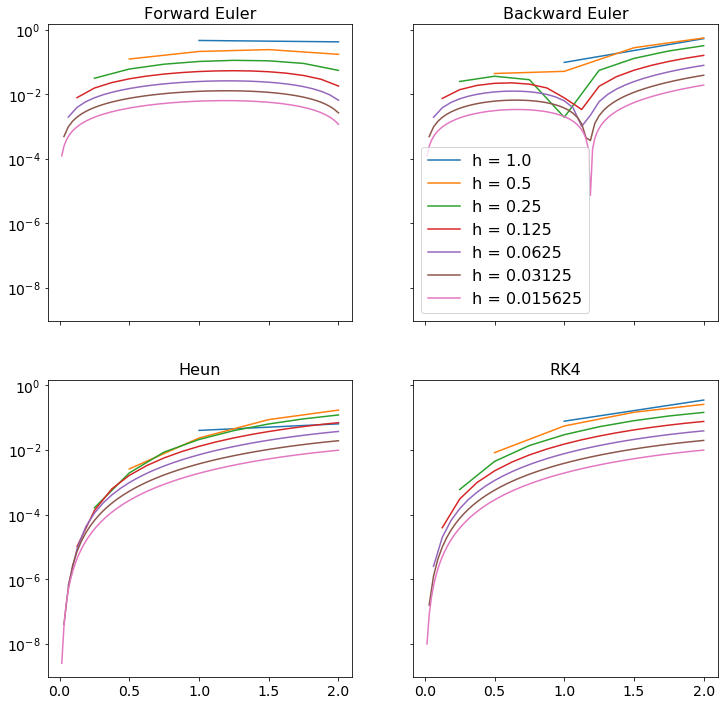

In [15]:
T = 2
hlst = 2.**(-np.arange(0,7))

def fsys(t, x):    
    return np.array([x[1], x[2], np.sin(t) - x[0] - x[2]])

x0 = np.array([1,0,-1])


f, axarray = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12,12))
for j, h in enumerate(hlst):
    n = np.int(T/h)
    
    #Forward Euler
    t1, xtraj1 = forward_euler(fsys, x0, h, n)
    err1 = np.abs(np.cos(t1)-xtraj1[0,:])
    axarray[0,0].semilogy(t1[1:], err1[1:])
    
    #Backward Euler
    t3, xtraj3 = backward_euler(fsys, x0, h, n)
    err3 = np.abs(np.cos(t3)-xtraj3[0,:])
    axarray[0,1].semilogy(t3[1:], err3[1:])
    
    #Heun's method
    t2, xtraj2 = heun(fsys, x0, h, n)
    err2 = np.abs(np.cos(t2)-xtraj2[0,:])
    axarray[1,0].semilogy(t2[1:], err2[1:])
    
    #RK4
    t4, xtraj4 = RK4(fsys, x0, h, n)
    err4 = np.abs(np.cos(t4)-xtraj4[0,:])
    axarray[1,1].semilogy(t4[1:], err4[1:])


axarray[0,0].set_title('Forward Euler', fontsize = 16)
axarray[1,0].set_title('Heun', fontsize = 16)
axarray[0,1].set_title('Backward Euler', fontsize = 16)
axarray[1,1].set_title('RK4', fontsize = 16)

strname = ['h = ' +  str(h) for h in list(hlst)]
axarray[0,1].legend(tuple(strname), fontsize = 16)

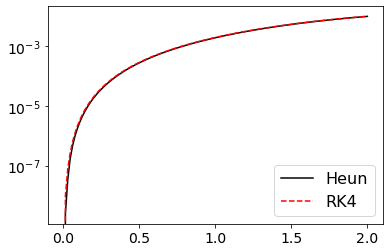

In [16]:
plt.semilogy(t2, err2, 'k-', t4, err4, 'r--')
plt.legend(('Heun', 'RK4'), fontsize = 16)

### Testing the bound

Our analysis gave the bound 

$$ |e_n| \leq \frac{T}{L_\Phi} \left( e^{(t_f-t_0) L_\Phi} - 1\right).$$

For Forward Euler, this bound simplifies to 

$$ |e_n| \leq \frac{h M_2}{2L_\Phi} \left( e^{(t_f-t_0) L_\Phi} - 1\right) \qquad M_2 = \max_{t\in[t_0,t_f]} |x''(t)|.$$

(Suli and Mayers) For the ODE 

$$ x'(t) = \tan^{-1}(x), \qquad x(0) = x_0, $$

we can show that $L_\Phi = 1$ and $M_2 \leq \pi/2$, so that 

$$ |e_n| \leq \frac{h \pi}{4} \left( e^{(t_f-t_0)} - 1\right). $$


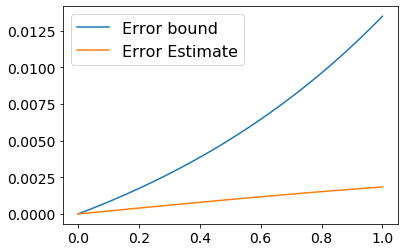

In [24]:
ftest = lambda t, x: np.arctan(x)


n = 100; h = 0.01; x0 = np.array([1])
t1, xtraj1 = forward_euler(ftest, x0, h, n)
t2, xtraj2 = RK4(ftest, x0, h, n)



bound = h*np.pi/4*(np.exp(t1)-1)
plt.plot(t1, bound, t1, np.abs(xtraj2-xtraj1).flatten())
plt.legend(('Error bound', 'Error Estimate'), fontsize = 16)

However, this gives us a way of picking the step size 

$$ \frac{h \pi}{4} \left( e^{(t_f-t_0)} - 1\right) \leq \epsilon, \qquad \Longrightarrow \qquad  h \leq  \frac{4\epsilon}{\pi( e^{\tau} - 1)  }, \qquad \tau = t_f-t_0. $$ 